# Record 1, 11.15.20, 11:20 AM
Nice day for bioinformatics.

## 1) Downloading data from roommate (R.I.P.)
```bash
wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/001/SRR1705851/SRR1705851.fastq.gz
# connection refused
```
Скачал с http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/001/SRR1705881/

1433060 lines

In [1]:
from IPython.display import display, Image
import pandas as pd
import numpy as np

In [2]:
Image(url='https://sun9-46.userapi.com/JIRQ1_oiapoqy4vPUkVFZVibvqKj1Nw3SXUWwQ/xOHqfNvUjD0.jpg', width=500)

Вроде бы всё "хорошо" - есть много дубликатов, из-за чего ещё ломается Per base sequence content. 

### Reference:

1665 bp https://www.ncbi.nlm.nih.gov/nuccore/KF848938.1?report=fasta

## 2) Alignment

индексирование
```bash
bwa index reference.fasta
```
выравнивание | сжатие в .bam | сортировка и запись в файл
```bash
bwa mem reference.fasta SRR1705851.fastq | samtools view -S -b | samtools sort - -o alignment.bam

samtools flagstat alignment.bam
```
99.94% mapped


## 3) Common Variant Calling

index bam file
```bash
samtools index alignment.bam
```
(What is the desired value of d if we want to keep all possible variants, given the length of the reference sequence, the number of reads, and the average read length?)
IGV показывает, что максимальная глубина покрытия - 44522.
```bash
samtools mpileup -d 44600 -f reference.fasta alignment.bam > roommate.mpileup
```
95%
```bash
in:
java -jar VarScan.v2.3.9.jar  mpileup2snp roommate.mpileup --min-var-freq 0.95 --variants --output-vcf 1 > VarScan_roommate.vcf

out:
...
1665 bases in pileup file
5 variant positions (5 SNP, 0 indel)
0 were failed by the strand-filter
5 variant positions reported (5 SNP, 0 indel)
```
"Pooling the variants out":
```bash
cat VarScan_roommate.vcf | awk 'NR>24 {print $1, $2, $4, $5}'

out:
KF848938.1 72 A G
KF848938.1 117 C T
KF848938.1 774 T C
KF848938.1 999 C T
KF848938.1 1260 A C
```
Выписал все кодоны

In [22]:
s = """KF848938.1 72 A G
KF848938.1 117 C T
KF848938.1 774 T C
KF848938.1 999 C T
KF848938.1 1260 A C"""

In [26]:
df = pd.DataFrame([[line.split()[1], line.split()[2], line.split()[3]] for line in s.split('\n')], columns=['Position', 'Reference', 'Alternative'])
df

,Position,Reference,Alternative
0,72,A,G
1,117,C,T
2,774,T,C
3,999,C,T
4,1260,A,C


### Do these mutations affect the protein? Let's find out!

In [80]:

for i in range(0, len(dna), 3):
    for r in df.iterrows():
        position = int(r[1][0]) - 1
        if position in range(i, i+3):
            original = dna[i:i+3]
            alternative = dna[i:position] + r[1][2] + dna[position+1:i+3] 
            res = str(position+1) + " " + original + ' to ' + alternative
            # print(position + 1, original, 'to', alternative)
            original = original.replace('T', 'U')
            alternative = alternative.replace('T', 'U')
            print(res, codons[original], 'to', codons[alternative])

72 ACA to ACG T to T
117 GCC to GCT A to A
774 TTT to TTC F to F
999 GGC to GGT G to G
1260 CTA to CTC L to L


In [87]:
s = """KF848938.1 72 A G ACA to ACG T to T
KF848938.1 117 C T GCC to GCT A to A
KF848938.1 774 T C TTT to TTC F to F
KF848938.1 999 C T GGC to GGT G to G
KF848938.1 1260 A C CTA to CTC L to L""" 

In [91]:
df = pd.DataFrame([[line.split()[1], line.split()[4], line.split()[6], 
                    line.split()[7], line.split()[9]] for line in s.split('\n')],
                 columns=['Position', 'Original codon', 'Alternative codon', 
                          'Original AA', 'Alternative AA'])
df

,Position,Original codon,Alternative codon,Original AA,Alternative AA
0,72,ACA,ACG,T,T
1,117,GCC,GCT,A,A
2,774,TTT,TTC,F,F
3,999,GGC,GGT,G,G
4,1260,CTA,CTC,L,L


## 4) Rare variants calling

```bash
java -jar VarScan.v2.3.9.jar  mpileup2snp roommate.mpileup --min-var-freq 0.001 --variants --output-vcf 1 > VarScan_roommate_rare.vcf

out:
1665 bases in pileup file
23 variant positions (21 SNP, 2 indel)
0 were failed by the strand-filter
21 variant positions reported (21 SNP, 0 indel)

in:
cat VarScan_roommate_rare.vcf | awk 'NR>24 {print $1, $2, $4, $5, $10}'

out:
KF848938.1 72 A G 1/1:255:16832:16794:6:16787:99.96%:0E0:35:36:4:2:10898:5889
KF848938.1 117 C T 1/1:255:20768:20663:36:20625:99.82%:0E0:35:37:27:9:13462:7163
KF848938.1 254 A G 0/1:20:35781:35626:35562:59:0.17%:8.5683E-3:36:36:23919:11643:37:22
KF848938.1 276 A G 0/1:24:37022:36965:36892:64:0.17%:3.3004E-3:37:35:22579:14313:30:34
KF848938.1 307 C T 0/1:255:37506:37386:37029:351:0.94%:6.9068E-66:36:35:22400:14629:184:167
KF848938.1 340 T C 0/1:23:37973:37793:37723:64:0.17%:4.6441E-3:37:36:23413:14310:40:24
KF848938.1 389 T C 0/1:40:31960:31763:31690:69:0.22%:9.0525E-5:37:36:16067:15623:44:25
KF848938.1 691 A G 0/1:23:39503:39319:39245:67:0.17%:4.1867E-3:37:34:21313:17932:23:44
KF848938.1 722 A G 0/1:36:38090:38036:37954:76:0.2%:2.353E-4:37:36:21003:16951:39:37
KF848938.1 744 A G 0/1:23:38443:38380:38306:65:0.17%:5.0068E-3:37:33:20859:17447:35:30
KF848938.1 774 T C 1/1:255:38397:38191:8:38177:99.96%:0E0:32:37:7:1:19806:18371
KF848938.1 802 A G 0/1:59:44223:44093:43988:101:0.23%:1.2224E-6:37:35:20575:23413:32:69
KF848938.1 859 A G 0/1:25:35882:35708:35642:63:0.18%:3.029E-3:37:36:14499:21143:27:36
KF848938.1 915 T C 0/1:30:37013:36912:36833:69:0.19%:8.2326E-4:35:34:18059:18774:37:32
KF848938.1 999 C T 1/1:255:32561:32115:40:32070:99.86%:0E0:35:36:23:17:17184:14886
KF848938.1 1043 A G 0/1:25:31638:31590:31529:58:0.18%:2.756E-3:35:33:17353:14176:19:39
KF848938.1 1086 A G 0/1:29:25259:25258:25203:53:0.21%:1.0076E-3:36:35:12596:12607:21:32
KF848938.1 1213 A G 0/1:34:25177:25093:25035:56:0.22%:3.7244E-4:37:36:8964:16071:24:32
KF848938.1 1260 A C 1/1:255:23067:23033:2:23019:99.94%:0E0:32:37:0:2:9824:13195
KF848938.1 1280 T C 0/1:20:23487:23462:23418:43:0.18%:9.2875E-3:37:35:11147:12271:24:19
KF848938.1 1458 T C 0/1:255:27064:26929:26701:225:0.84%:3.4507E-41:37:35:6865:19836:80:145
```
Частоты в 7-ой колонке: 99.96%, 99.82% и т.д.

# Эпизод 5: Выравнивание клонов
- SRR1705858: ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/008/SRR1705858/SRR1705858.fastq.gz 
- SRR1705859: ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/009/SRR1705859/SRR1705859.fastq.gz 
- SRR1705860: ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/000/SRR1705860/SRR1705860.fastq.gz 
файлы clone1, clone2, clone3 (.fastq)

Количества ридов клонов:
1. 256586
2. 233327
3. 249964

Выравниваем и индексируем для каждого клона (файлы `alignment_clone1.bam`, ...)

Найдём максимальную глубину покрытия для выравниваний клонов:
```bash
samtools depth -d 0 alignment_clone1.bam > depth1.txt
```

In [3]:
max_depth = {
    1: pd.read_csv('Data/depth1.txt', sep='\t')['8511'].max(),
    2: pd.read_csv('Data/depth2.txt', sep='\t')['7661'].max(),
    3: pd.read_csv('Data/depth3.txt', sep='\t')['8903'].max()
}

In [4]:
for k, v in max_depth.items():
    print(k, v)

1 35782
2 32837
3 36262


# 6) Получение и анализ вариантов у клонов

Для каждого из клонов делаем м-кучу вверх и ищем варианты:
```bash
samtools mpileup -d 36600 -f reference.fasta alignment_clone1.bam > clone1.mpileup

java -jar VarScan.v2.3.9.jar  mpileup2snp clone1.mpileup --min-var-freq 0.001 --variants --output-vcf 1 > VarScan_clone1.vcf
```
### Парсинг, загон в пандас и парсинг:
```bash
cat VarScan_clone1.vcf | awk 'NR>24 {print $1, $2, $4, $5, $10}' > variants_clone1.txt
cat VarScan_clone2.vcf | awk 'NR>24 {print $1, $2, $4, $5, $10}' > variants_clone2.txt
cat VarScan_clone3.vcf | awk 'NR>24 {print $1, $2, $4, $5, $10}' > variants_clone3.txt
```

In [5]:
vc1 = pd.read_csv('Data/variants_clone1.txt', sep=' ', header=None)
vc1.drop(0, axis=1, inplace=True)
vc1.columns = ['Position', 'Reference', 'Alternate', 'Freq']
vc1['Freq'] = vc1.Freq.apply(lambda x: float(x.split(':')[6][:-1]))
vc1.head()

,Position,Reference,Alternate,Freq
0,38,T,C,0.66
1,54,T,C,0.30
2,72,A,G,0.30
3,95,A,G,0.24
4,117,C,T,0.30


In [6]:
vc2 = pd.read_csv('Data/variants_clone2.txt', sep=' ', header=None)
vc2.drop(0, axis=1, inplace=True)
vc2.columns = ['Position', 'Reference', 'Alternate', 'Freq']
vc2['Freq'] = vc2.Freq.apply(lambda x: float(x.split(':')[6][:-1]))
vc2.head()

,Position,Reference,Alternate,Freq
0,44,T,C,0.47
1,158,A,G,0.24
2,165,T,C,0.27
3,183,A,G,0.22
4,193,A,G,0.22


In [7]:
vc3 = pd.read_csv('Data/variants_clone3.txt', sep=' ', header=None)
vc3.drop(0, axis=1, inplace=True)
vc3.columns = ['Position', 'Reference', 'Alternate', 'Freq']
vc3['Freq'] = vc3.Freq.apply(lambda x: float(x.split(':')[6][:-1]))
vc3.head()

,Position,Reference,Alternate,Freq
0,38,T,C,0.70
1,44,T,C,0.50
2,95,A,G,0.24
3,105,A,G,0.25
4,133,A,G,0.22


### Считаем среднuе и ско для частот замен.

In [209]:
VC = [vc1, vc2, vc3]
mu = {}
std = {}
number = {}
for i, vc in enumerate(VC):
    mu[i+1] = vc.Freq.mean()
    std[i+1] = vc.Freq.std()
    number[i+1] = vc.Freq.size
    
clone_stats = pd.DataFrame(columns=['Total mutations', 'Mean frequency, %', 'STD of frequencies, %'])
for i in range(1, 4):
    clone_stats = clone_stats.append({'Total mutations': number[i], 'Mean frequency, %': mu[i], 
                        'STD of frequencies, %': std[i]}, ignore_index=True)
# clone_stats.set_index('#')
clone_stats

,Total mutations,"Mean frequency, %","STD of frequencies, %"
0,57.0,0.256491,0.071726
1,52.0,0.236923,0.052376
2,61.0,0.250328,0.078038


# 7) Сравнение соседа с клонами

In [129]:
# Сосед
vrm = pd.read_csv('Data/variants_roommate.txt', sep=' ', header=None)
vrm.drop(0, axis=1, inplace=True)
vrm.columns = ['Position', 'Reference', 'Alternate', 'Freq']
vrm['Freq'] = vrm.Freq.apply(lambda x: float(x.split(':')[6][:-1]))
vrm.head()

,Position,Reference,Alternate,Freq
0,72,A,G,99.96
1,117,C,T,99.82
2,254,A,G,0.17
3,276,A,G,0.17
4,307,C,T,0.94


In [10]:
# Clone 1
i = 1
vrm[np.abs(vrm.Freq - mu[i]) > 3 * std[i]]

,Position,Reference,Alternate,Freq
0,72,A,G,99.96
1,117,C,T,99.82
4,307,C,T,0.94
10,774,T,C,99.96
14,999,C,T,99.86
18,1260,A,C,99.94
20,1458,T,C,0.84


In [11]:
# Clone 2
i = 2
vrm[np.abs(vrm.Freq - mu[i]) > 3 * std[i]]

,Position,Reference,Alternate,Freq
0,72,A,G,99.96
1,117,C,T,99.82
4,307,C,T,0.94
10,774,T,C,99.96
14,999,C,T,99.86
18,1260,A,C,99.94
20,1458,T,C,0.84


In [100]:
# Clone 3
i = 3
vrm[np.abs(vrm.Freq - mu[i]) > 3 * std[i]]

,Position,Reference,Alternate,Freq
0,72,A,G,99.96
1,117,C,T,99.82
4,307,C,T,0.94
10,774,T,C,99.96
14,999,C,T,99.86
18,1260,A,C,99.94
20,1458,T,C,0.84


# Record 2, 11.16.20, 15:58


## 8)  Epitope mapping (Munoz et al)

In [175]:
s = """Epitope A (residues 122, 124,
126, 130–133, 135, 137, 138, 140, 142–146, 150, 152, 168)
presents one point mutation at residue 131. The calculated
value p epitope = 1/19 = 0.053. Epitope B (residues 128, 129,
155–160, 163, 165, 186–190, 192–194, 196–198) presents
three point mutations at residues 155, 156, and 186. The
calculated value p epitope = 3/21 = 0.14. Epitope C (residues
44–48, 50, 51, 53, 54, 273, 275, 276, 278–280, 294, 297,
299, 300, 304, 305, 307–312) presents one point mutation at
residue 50. The calculated value p epitope = 1/27 = 0.037. Epi-
tope D (residues 96,102,103,117,121,167,170–177,179,182,
201, 203, 207–209, 212–219, 226–230, 238, 240, 242, 244,
246–248) presents no mutations. Epitope E (residues 57, 59,
62, 63, 67, 75, 78, 80–83, 86–88, 91, 92, 94, 109, 260–262,
265)"""

In [194]:
epitopes = ['A', 'B', 'C', 'D', 'E']

Mapping = {ep: list() for ep in epitopes}
cur = -1
for word in s.replace(',', ' ').replace(')', ' ').replace('(', ' ').split():
    if word in epitopes:
        cur += 1
    elif word.isdigit() and len(word) < 4:
        Mapping[epitopes[cur]].append(int(word))
    elif len(word.split('–')) == 2:
        a, b = map(int, word.split('–'))
        for i in range(a, b+1):
            Mapping[epitopes[cur]].append(i)
        
for e in epitopes:
    Mapping[e] = set(Mapping[e])
    
    nucl = set()  #
    for pp in Mapping[e]:
        nucl = nucl.union([3*pp, 3*pp-1, 3*pp-2])
    Mapping[e] = nucl


In [204]:
vrm_final = vrm[np.abs(vrm.Freq - mu[1]) > 3 * std[1]]
vrm_final[vrm_final.Position.apply(lambda x: x in Mapping['D'])]

,Position,Reference,Alternate,Freq
4,307,C,T,0.94


Итак, имеется единственная замена в эпитопе D:
- 307 	C 	T 	0.94

## Найдём замены аминокислот

Поскольку я до сих пор не шибко уверен, как тут работает кодирование, то перебрал несколько вариантов. Последовательности сходятся, если в гене заменить T на U и использовать таблицу РНК 

In [16]:
with open('Data/reference.fasta', 'r') as f:
    ref = f.read()
dna = ''.join(ref.split('\n')[1:])

In [17]:
aa = """QKLPGNDNSTATLCLGHHAVPNGTIVKTITNDQIEVTNATELVQ
                     SSSTGEICNSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAHSNCYPYDV
                     PDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSNNSFFSRLNWLTHLNFK
                     YPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQAAGRITVSTKRSQQAVIPNIG
                     SRPRVRNIPSRVSIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGK
                     CNSACITPNGSIPNDKPFQNVNRITYGACPRYVKQNTLKLATGMRNVPEKQTRGIFGA
                     IAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKF
                     HQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEK
                     TKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHDVYRDEALNNRFQIKGVELK
                     SGYKDWILWISFAISCFLLCVALLGFIMWACQKGNIRCNICI"""
aa = ''.join(aa.replace(' ', '').split('\n')) 
aa

'QKLPGNDNSTATLCLGHHAVPNGTIVKTITNDQIEVTNATELVQSSSTGEICNSPHQILDGENCTLIDALLGDPQCDGFQNKKWDLFVERSKAHSNCYPYDVPDYASLRSLVASSGTLEFNNESFNWTGVTQNGTSSACIRRSNNSFFSRLNWLTHLNFKYPALNVTMPNNEQFDKLYIWGVHHPGTDKDQIFLYAQAAGRITVSTKRSQQAVIPNIGSRPRVRNIPSRVSIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCNSACITPNGSIPNDKPFQNVNRITYGACPRYVKQNTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQINGKLNRLIGKTNEKFHQIEKEFSEVEGRIQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNGTYDHDVYRDEALNNRFQIKGVELKSGYKDWILWISFAISCFLLCVALLGFIMWACQKGNIRCNICI'

In [18]:
%run codons.py

In [217]:
# аминокислоты на референсе
test_aa = ""
dna_U = dna.replace('T', 'U')
for i in range(0, 1656, 3):
    if i + 2 == 1457 or i == 306:
        acid = codons[dna_U[i:i+3]]
        print(i + 1)
        print(dna[i:i+3])
        print(acid)

307
CCG
P
1456
TAT
Y


In [219]:
print(codons['UCG'], codons['UAC'])  # на 103 позиции - P => S; на 486 позциции - Y => Y

S Y


# 9) PyMOL

В консоль `fetch 2yp7`

Выделил замены большими красными шарами!

## На самом деле актуальная только та, что ниже

In [21]:
Image(url='https://sun9-15.userapi.com/oUH8jHk50X6K_x2lNTJ38JRea2DP-OKHaVUTyA/GdnQKk_ylsQ.jpg')

In [221]:
clones = vc1.append(vc2).append(vc3)

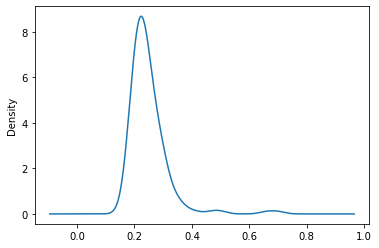

In [227]:
clones.Freq.plot(kind='kde');